#### Imports

In [881]:
# Execute before using this notebook if using google colab
kernel = str(get_ipython())
if 'google.colab' in kernel:    
    !wget https://raw.githubusercontent.com/fredzett/rmqa/master/utils.py -P local_modules -nc 
    !npx degit fredzett/rmqa/data data
    import sys
    sys.path.append('local_modules')

In [882]:
import numpy as np
import pandas as pd
from utils import plot_line, plot_scatter
import scipy.stats as stats
from patsy import dmatrices#
import statsmodels.api as sm
from sklearn import metrics

# Logistic regression

## Introduction

Many practical and research problems deal with issues where the _dependent variable_ ($Y$) is _categorical_. Consider, for example, the following problems:

1. will patient be cured by taking a certain medicine or not

2. what are factors driving a customer's decision to cancel his/her contract

3. which of the five available parties will people vote for?

All of these questions have in common that the dependent variable is categorical. Problems 1 and 2 deal with questions where two alternatives exist, whereas in problem 3 more than two alternatives exist. 

Note that even if the dependent variable is not binary - e.g. net income - you may be that your research question or decision relevant information is binary (did you make a loss or a profit). 

__Logistic regression__ is well suited to answer questions such as the above. Here the dependent variable $Y$ is a categorical variable whose values ($g = 1, \ldots, G)$ represent the alternatives available. For example, in problem 2, $Y$ could take the value $0$ or $1$ representing a customer cancelling a contract or not. In problem 3, $Y$ could take values of $0, \ldots, 4$ to represent the five available parties. Theoretically, other values are possible but commonly we use $0$ and $1$ for the binary case. 

We use different terminology to distinguish between the two cases described above:

1. Binary logistic regression for $G = 2$

2. Multinomial logistic regression for $G \geq 3$



The __logistic regression model__ can be generally expressed as follows:

$$\pi(x) = f(x_1, \ldots, x_J)$$

Where $\pi(x)=P(Y = 1 | x)$ is the conditional probability that for event 1 (e.g. customer cancels contract) occurs given the independent / explanatory variables $x_1, \ldots, x_J$. Identical to the linear regression model the explanatory variables are expressed using a linear combination 

$$z(x) = \beta_0 + \beta_1x_1 + \ldots + \beta_Jx_J$$

The logistic regression receives its name from the (standard) __logistic function__ 

$$p = \frac{e^z}{1+e^z}= \frac{1}{1+e^{-z}}$$

(Note: simpliefied by multiplying with $1/e^z$)

Plotting the function (here: bewteen -5 and 5) reveals its s-shaped distribution. The function can hence be interpreted as a cumulative probabilitby distribution function and it is similar to the cumulative (standard) normal distribution as you can see from the below plot:

In [820]:
# logistic function
def p(z):
    return 1 /(1+np.exp(-z))

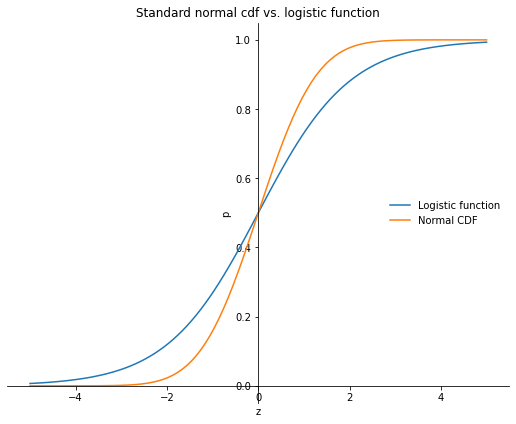

In [821]:
z = np.linspace(-5,5,100)  # 100 x values from -5 to 5
norm = stats.norm(0,1)
fig, ax = plot_line(z, [p(z),norm.cdf(z)], xlabel="z", ylabel="p",title="Standard normal cdf vs. logistic function", zero_origin=True);
ax.legend(("Logistic function","Normal CDF"), frameon=False, loc="right");

The logistic function is applied in a broad range of applications as it is mathematically less complex than the normal distribution. By using a lostistic function we can **transform** real numbers into probabilities, i.e. transform numbers in the range of $[-\infty, +\infty]$ to the range $[0, 1]$. Specifically, transforming the _systematic component_ using the _logistic function_ yields the __logistic regression function__:

$$\pi(x)=\frac{1}{1+e^{-z(x)}}$$

The larger the systematic component $z(x)$, the higher $\pi(x)$. Therefore: the higher $z(x)$, the higher $P(Y = 1 | x)$.

In line with our discussion in Chapter 5 (linear regresssion) we will now examine how to use logistic regression by explaining

1. model formulation

2. estimation of logistic regression function

3. interpretation of regression coefficients

4. assessment of overall model

5. assessment of coefficients

We will largely rely on the explanaitons and the dataset used in  [*Backhaus et al (2017)*](https://www.springer.com/de/book/9783662460764).

### Dataset
**Data set**: the data set contains (toy) data on a product test where people where shown a product (premium butter) and asked if they would buy it. The dataset includes the following variables:

- person: id of person

- income: income of person buying / not buying the product (here: premium butter)

- gender: gender of person buying / not buying the product ($0 =$ female, $1 =$ male)

- purchase: indicator for purchasing decision ($0=$ no purchase, $1=$ purchase)

The data has 30 observations.

In [822]:
df = pd.read_csv("./Data/testpurchase.csv")
df["income"] = df["income"] / 1000 # makes interpretation of coefficients easier
df.head(5)

,person,income,gender,purchase
0,1,2.53,0,1
1,2,2.37,1,0
2,3,2.72,1,1
3,4,2.54,0,0
4,5,3.20,1,1


In [823]:
df.shape

(30, 4)

## Model formulation

Let's consider a simple example where we analyze the purchase decision and treat only _income_ as a explanatory variable. This yields the following model:

$$Y = f(\text{income})$$

where $Y=1$ for purchase and $0$ for no purchase. 

We are interested in how income is driving the purchase decision. Let's look at this relationship graphically first:

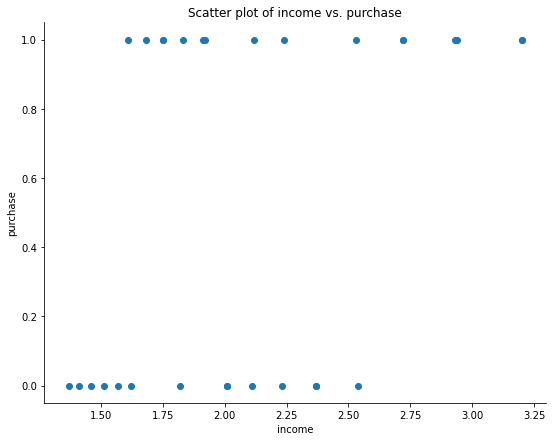

In [824]:
xmin, xmax = min(df["income"]), max(df["income"])

fig, ax = plot_scatter(df["income"], df["purchase"], zero_origin=False, xlabel="income", ylabel="purchase", title="Scatter plot of income vs. purchase")
ax.set_xlim((xmin-0.1,xmax+0.1));

The upper marks represent people who stated that the would purchase the product. The lower marks represents people who indicated that they would not purchase the product. From the plot it becomes obvious that there is no exact relationship between income and purchase. For example, for the income of $\sim 2.500$ there is a mark for both purchase and no purchase. 

However, visually it appears that the higher the income the more likely is the purchasing decision. For example, above an income of $\sim2.600$ there are only purchasing decisions.

Let us try to formulate a model that captures this realationship.

### Linear (probability) model

The simplest model is the linear model which is given by:

$$\pi(x_k) = \beta_0 + \beta_1x_k$$

Here $\pi(x_k)$ gives the purchase probabilities of test persons. These probabilities are modelled such that they are linear dependent on the income of the test persons. While the probabilities cannot be observed they are derived from the purchasing data. 

Let's calculate the model using python:

In [825]:
y, X = dmatrices("purchase ~ income", df)

In [826]:
ols = sm.OLS(y,X).fit()
ols.params

array([-0.28332301,  0.38612593])

In [827]:
xs = np.linspace(xmin,xmax,100)#.reshape(None)
xs = sm.add_constant(xs)
yhat = ols.predict(xs)

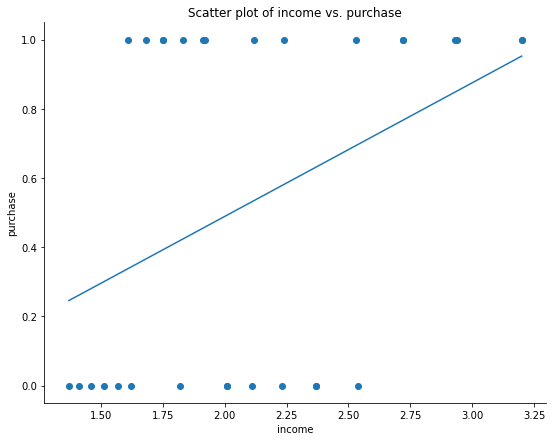

In [828]:
ax.plot(xs[:,1], yhat)
fig

The model is already known and quite simple. Especially we already know how to interpret the model. For example, given the mean income is $2.000$ we can say that the purchase probability at the this income level is 

$$p(purchase) = -0.2833 + 0.3861 \times 2 \approx 0.5$$

Therefore the probability is approx. 50% that a person with an income of $2.000$ would purchase the product. This is easy to interpret and we are alredy familiar with all the model characteristics from chapter 5. However, the model is logically flawed given the probabilities can take values of below 0 and above 1 in theory. For our specific example a person with an income of $5.000$ would have a (calculated) probability of 

$$p(purchase) = -0.2833 + 0.3861 \times 5 \approx 1.65,$$

i.e. there would be a probability of 165% calculated by the model. 


### Logistic regression

The binary logistic regression model is expressed as follows:

$$\pi(x_k) = \frac{1}{1+e^{-(\beta_0 + \beta_1x_k)}}$$

The model assumes that $Y_k$ (i.e. the purchase decisions) is a binary, independent random variable with expected value $E(Y_k | x_k) = \pi(x_k)$. To this end, the model assumes that $Y_k$ is _bernoulli_ distributed. 


Let's calculate the logistic regression model using the `statsmodels` package: this can easily be done using a similar syntax as for the linear regression model:

`sm.Logit(y,X)` instead of `sm.OLS(y,X)`

In [829]:
logit = sm.Logit(y,X).fit()
logit.params

Optimization terminated successfully.
         Current function value: 0.600896
         Iterations 5


array([-3.67071835,  1.82716993])

   
The parameter of the model are 

- $\beta_0 = -3.6707$
- $\beta_1 = 1.8272$

which yields the following logistic function:

$$p(x_k) = \frac{1}{1+e^{-(-3.6707 + 1.8272x_k)}}$$

Including the logistic function in our plot we see that the slope of the function is quite similar to the linear model. However, the function is s-shaped and can only take values between $0$ and $1$ by definition which makes it better suited for our analysis. 

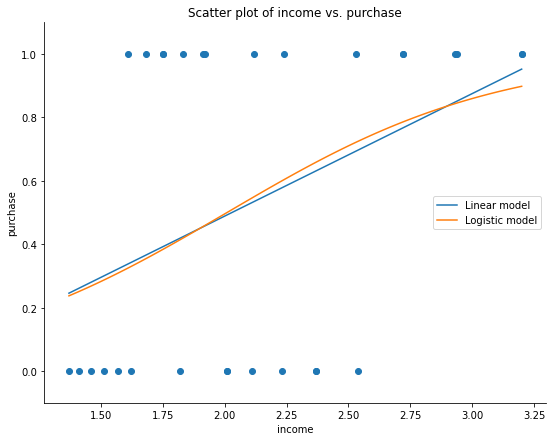

In [830]:
yhat2 = logit.predict(xs)
ax.plot(xs[:,1], yhat2)
ax.set_ylim(-0.1,1.1)
ax.legend(("Linear model","Logistic model"), loc="right")
fig

#### Classification

How can we use the estimated probabilities for prediction of purchase behavior? 

In order to do so we need to define a __cut off value__ $p*$ such that

\begin{equation}
  y_k =\begin{cases}
    1, & \text{if $p_k > p*$} \\
    0, & \text{if $p_k \leq p*$}
  \end{cases}
\end{equation}

Commonly, a cut of value of $0.5$ is used. This means that 

- all $y_k$ with a value (probability) of above 50% are assigned 1 and
- all $y_k$ with a value (probability) of equal or below 50% are assigned a 0

Let's analyse how good our logistic regression model is in classifying purchasing decisions using our data. 

We can use our estimated model and predict _purchase probability_ based on _income_ data. We can then compare with our true values to see how could our model actually is. 

In [831]:
df_final = df.copy() # copy our dataframe
probas = logit.predict(X) # estimate probabilities using predict. 
df_final["probabilities"] = probas
df_final["prediction"] = np.where(probas>0.5,1,0)

In [833]:
df_final.head()

,person,income,gender,purchase,probabilities,prediction
0,1,2.53,0,1,0.721522,1
1,2,2.37,1,0,0.659187,1
2,3,2.72,1,1,0.785698,1
3,4,2.54,0,0,0.725178,1
4,5,3.20,1,1,0.898094,1


#### Confusion matrix

If we want to understand how good our prediction was we can calculate the __confusion matrix__. It calculates true values vs. predicted values for each category. A summary of this overview is helpful as it gives inside to three different measures:

- accuracy: % of correct predictions 
- specificity: % of correctly classified non purchases in relation to all non-purchases (correct false)
- sensitivity: % of correctly classified purchases in relation to all purchases (correct trues)

Let's look at the below table summarizing the results:

|       	| Prediction 	|    	|       	|           	|             	|
|-------	|------------	|----	|-------	|-----------	|-------------	|
|       	| 0          	| 1  	| Total 	| % correct 	|             	|
| 0     	| 7          	| 7  	| 14    	| 50,00%    	| Specificity 	|
| 1     	| 7          	| 9  	| 16    	| 56,25%    	| Sensitivity 	|
| Total 	| 14         	| 16 	| 30    	| 53,33%    	|   Accuracy  	|


accuracy: 
- we have classified 7 non-purchases and 9 purchases correcty
- in total there were 30 observations
- (7+9)/30 = 0.533

__sensitivity__, i.e. proportion of correctly predicted purchases in relation to all purchases
- we have classified 9 purchases out of 16 purchases correctly
- 9 / 16 = 0.563

__specificity__, i.e. proportion of correctly predicted non-purchases in relation to all non-purchases
- we have classified 7 non-purchases out of 14 non-purchases correctly
- 7 / 14 = 0.500


In more general form we can say:

|   	| Prediction     	|                	|
|---	|----------------	|----------------	|
|   	| 0              	| 1              	|
| 0 	| True negative  	| False positive 	|
| 1 	| False negative 	| True positive  	|


$$\text{accuracy} = \frac{TN + TP}{\text{total observations}}$$

$$\text{sensitivity} = \frac{TP}{\text{TP + FN}}$$

$$\text{specificity} = \frac{TN}{\text{TN + FP}}$$

Where:
- false positive is also called the Type I error and
- false negative is also called the Type II error

It is important to look at all three measures for several reasons, e.g. accuracy may be misleading for unbalanced datasets  (e.g. fraudulent credit card transactions).

Also, it is important to be aware of the fact that there is a tradeoff between specificity and sensitivity. For example we can easily build a model that has a sensitivity of 100%. We could do so by simply classifying all observations as purchases. This would give a 100% sensitivity. On the other hand the specificity would be at 0% as we have not correctly classified one non-puchase observations. 

**Example sensitivity and specificity: diagnosis of a disease**

- sensitivity: "patient is sick and test is positive"

- specificity: "patient is not sick and test is negative"

When is high sensitivity or high specificity good or bad?   
- disease can be cured if diagnosed early: than a high sensitivity is good
- disease cannot be cured: than a high specificity is good as a high sensitivity increases chance for false positive and a wrongful diagnosis would leave a healthy person with the diagnosis that he/she has a uncurable disease.


We can eassily calculate the measures manually.

In [834]:
TN = df_final.query("purchase == 0 & prediction == 0").shape[0]
FN = df_final.query("purchase == 0 & prediction == 1").shape[0]
TP = df_final.query("purchase == 1 & prediction == 1").shape[0]
FP = df_final.query("purchase == 1 & prediction == 0").shape[0]

accuracy = (TP + TN) / (TN + FN + TP + FP)
sensitivity = TP / (TP + FN)
specificity = TN / (FP + TN )
accuracy, sensitivity, specificity

(0.5333333333333333, 0.5625, 0.5)

#### ROC Curve

One disadvantage of the confusion matrix is that it is a snapshot for one specific cutoff value $p*$. The __ROC curve__ visualizes correctness of classification over the continuum of possible cutoff points. 

The ROC curve plots sensitivity vs. 1 - specificity for different cutoff points. The diagonal line represents a model that a random prediction. A line along the top left corner represents a good classifier given it is able to 

- correctly identify purchases from all purchases while
- not wrongly identifying many purchases (e.g. if sensitivity is 1  because we simply always predict 1, then all non-purchases are wrongly predicted)

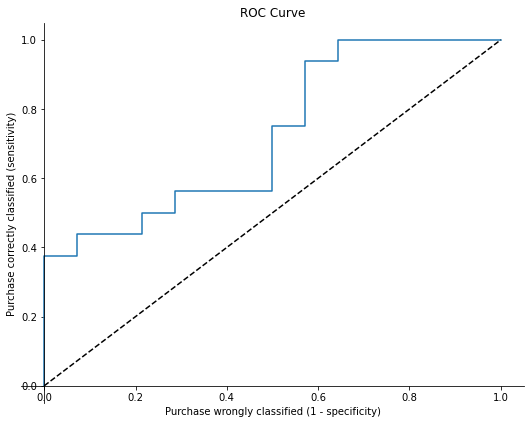

In [835]:
fpr, tpr, _ = metrics.roc_curve(purchases, probas, pos_label=1)
_, ax = plot_line(fpr, tpr, title="ROC Curve", xlabel = "Purchase wrongly classified (1 - specificity)", ylabel="Purchase correctly classified (sensitivity)");
thresholds = np.linspace(0, 1, 100)
ax.plot(thresholds, thresholds, color="black", linestyle="--");

### Multiple logistic regression

Up until now and similar to the linear regression model we have build a very simple model explaining the decision to purchase with exactly one (explanatory) variable: income. Intuitively there may be more than one factor / one variable driving the purchasing decision. Similar to the regression example we can extend the (binary) model to the case where multiple variables are included. This is called the __multiple logistic regression__.

Let $x_k = (x_{1k}, x_{2k}, \ldots, x_{Jk})$ be the set of values / observations for $J$ independent variables. Then the multiple logistic regression model is defined as (neglecting index $k$):

$$\pi(x) = \frac{1}{1+e^{-(\beta_0 + \beta_1x_1 + \ldots + \beta_Jx_J}}$$

This is commonly expressed in matrix form as

$$\pi(\mathbf{x}) = \frac{1}{1+e^{-\mathbf{x}\mathbf{\beta'}}}$$. 

For our example data the model could include _gender_ as a second explanatory variable. This would give us the following model:

$$Y = f(\text{income, gender})$$

which would lead to the following logistic model:

$$\pi(x_k) v

In [837]:
y, X = dmatrices("purchase ~ income + gender", df)
mlogit = sm.Logit(y,X).fit()
mlogit.params

Optimization terminated successfully.
         Current function value: 0.535087
         Iterations 6


array([-5.63484902,  2.35090459,  1.75135282])

The logistic regression function for our model therefore looks as follows:

$$p(\mathbf{X}_k) = \dfrac{1}{1+e^{-(-5.6348 + 2.3509x_{1k} +  1.7514x_{2k})}}$$

for $(k = 1, \ldots, K)$.

__Example:__ for the $4th$ person in our dataset, i.e. a woman with income of 2.54 (thousands) the following can be derived:

\begin{equation}
\begin{split}
z &= -5.6348 + 2.3509 \cdot 2.54 +  1.7514 \cdot 0 = 0.3365 \\
\Rightarrow p &= \frac{1}{1+e^{-0.3365}} = 0.5833
\end{split}
\end{equation}

Also, the positive coefficient for gender indicates that male ($=1$) tend to have a higher probability of buying the product. This can be confirmed using our model and assuming a male person that has equal income than our female example (i.e. $2.54$):

\begin{equation}
\begin{split}
z &= -5.6348 + 2.3509 \cdot 2.54 +  1.7514 \cdot 1 = 2.0879 \\
\Rightarrow p &= \frac{1}{1+e^{-2.0879}} = 0.8897
\end{split}
\end{equation}

In [838]:
df_final = df.copy() # copy our dataframe
probas = mlogit.predict(X) # estimate probabilities using predict. 
df_final["probabilities"] = probas
df_final["prediction"] = np.where(probas>0.5,1,0)

TN = df_final.query("purchase == 0 & prediction == 0").shape[0]
FN = df_final.query("purchase == 0 & prediction == 1").shape[0]
TP = df_final.query("purchase == 1 & prediction == 1").shape[0]
FP = df_final.query("purchase == 1 & prediction == 0").shape[0]

accuracy = (TP + TN) / (TN + FN + TP + FP)
sensitivity = TP / (TP + FN)
specificity = TN / (FP + TN )
accuracy, sensitivity, specificity

(0.8333333333333334, 0.8235294117647058, 0.8461538461538461)

Looking at the ROC curve we can see that the model looks better. 

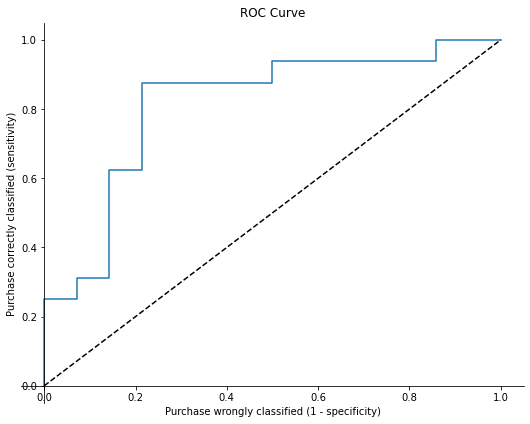

In [839]:
probas = mlogit.predict(X)
fpr, tpr, _ = metrics.roc_curve(purchases, probas, pos_label=1)
_, ax = plot_line(fpr, tpr, title="ROC Curve", xlabel = "Purchase wrongly classified (1 - specificity)", ylabel="Purchase correctly classified (sensitivity)");
ax.plot(thresholds, thresholds, color="black", linestyle="--");

## Estimation of logistic regression function

Unlike for the linear regression model there is no analytical solution to estimating the correct coefficients. This is due to the non-linearity of the function. When calculating the optimal logistic regression function we apply maximum likelihood method (MLE). When applying maximum likelihood we are estimating the coefficients such as the given data is most likely (i.e. plausible). 

This means that for a person k in our model the probability $p(x_k)$ should be high if $y_k = 1$ (low for $y_k = 0$). Mathematically this can be expressed as:

$$p(x_k)^{y_k}\cdot (1-p(x_k))^{1-y_k}$$

One assumption of the model is that $Y_k$ is independently distributed for all observations. This means that we can express the total probability over all observations as the product of individual probabilities. This yields the following __likelihood function__ that needs to be maximized:

$$L(\beta) = \prod_{k=1}^K p(x_k)^{y_k}\cdot (1-p(x_k))^{1-y_k} \rightarrow Max!$$

The $\beta$ parameter need to be estimated such that the likelihood is maximized. In practice it is more feasible to use the logarithm of the above function given we can replace the product with a sum which is simpler:

$$LL(\beta) = \sum_{k=1}^K ln[p(x_k)]\cdot y_k + ln[1-p(x_k)]\cdot(1-y_k) \rightarrow Max!$$

The solution to this maximization effort is found using _iterative approches_ such as gradient descent. 

## Interpretation of regression coefficiens

### Caution when interpreting coefficients

Given the nonlinearity of the logistic regression model it is somewhat more difficult to interpret the individual coefficients from our model optimization. One of the main challenges is that the impact of a coefficient is not constant but varies with the dependent variable. 

To this end, it is only possible to state: _how much the change of one parameter, changes the dependent variable_. However, it is not possible to state by how much the dependent variable changes as the slope of changes not constant.

Change of __intercept__ (i.e. $\beta_0$):  
- changes curve horizontally
- increase of $\beta_0$ increases probability for a given $x$ (and vice versa)

Change of __slope__ (i.e. $\beta_1$):
- increase of coefficient yields steeper curve in the mid range
- $\beta_1 = 0 $ yields a flat curve
- change in sign changes slope of curve (if negative slope is downward)

<br>

__Difficulty of interpretation:__ the impact of a coefficient is not constant on $Y$

- for linear regression we could say: a change in $x$ changes $y$ by $\beta$

- for logistic regression this change also is dependent on $y$ (i.e. the probability p). The biggest impact is when $p=0.5$


(Note: show interactive example; examples can be seen in [*Backhaus et al (2017)*](https://www.springer.com/de/book/9783662460764), p. 291ff

In [840]:
def sig(z):
    return 1 / (1 + np.exp(-z))

def z(a,b, xs):
    return a + b*xs

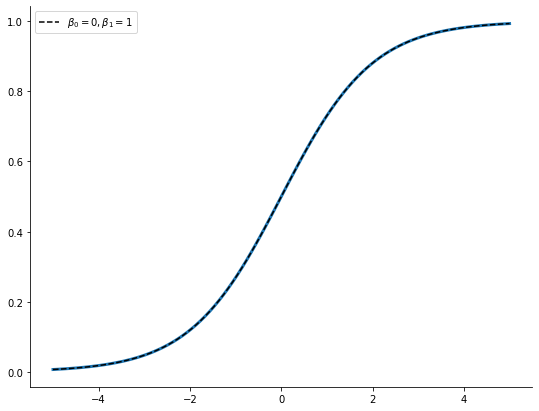

In [841]:
# Change a and b to see changes
a, b = 0, 1 
xs = np.linspace(-5,5,100)
p = sig(z(a,b,xs))
fig = plt.figure(figsize=(9,7))
plt.plot(xs, p, linewidth=3)
plt.plot(xs, sig(z(0,1,xs)), linestyle="--", color="black", label=r"$\beta_0=0, \beta_1=1$")
plt.legend()
sns.despine()

We can illustrate the fact that the impact of a coefficient is dependent on p (and is highest for $p=0.5$) by looking at our previous simple logistic regression model:

Here we calculated a probability of $\approx 50$% for an income of $2$ (i.e. 2.000 EUR).

In [842]:
income = 2
sig(-3.6707+1.8272*income)

0.4959250902214988

We can now calculate the values for different incomes and see that the change in probability will decrease, i.e. the impact of the coefficient becomes less the higher the probality gets.

In [843]:
incomes = [2, 3, 4, 5, 6, 7]
for income in incomes:
    p = sig(-3.6707+1.8272*income)
    if income == 2:
        print(f"For income: {income}, the probablity is {p:.2f}")
    if income != 2:
        print(f"For income: {income}, the probablity is {p:.3f}, change is {p/p_before - 1:.2f}")
    p_before = p

For income: 2, the probablity is 0.50
For income: 3, the probablity is 0.859, change is 0.73
For income: 4, the probablity is 0.974, change is 0.13
For income: 5, the probablity is 0.996, change is 0.02
For income: 6, the probablity is 0.999, change is 0.00
For income: 7, the probablity is 1.000, change is 0.00


### Odds-Ratio and Logit as help for interpretation

The logistic model can alternatively be expressed in _odds_ and _logits_ both of which simplifies interpretation. 

Odds and logit are defined as follows:

\begin{equation}
\begin{split}
\\[1.5ex]
\text{Odds} &= \frac{p}{1-p} = e^{\beta_0 + \beta_1x} =  e^{-3.6707 + 1.8272x} 
\\[3ex]
\text{Logit} &= ln\big(\frac{p}{1-p}\big) = \beta_0 + \beta_1x =  -3.6707 + 1.8272x
\end{split}
\end{equation}

#### Odds

__Odds__ can be interpreted as chance of winning and are calculated as a relation of probability $p$ and its counter probability $(1-p)$. Let's say the probability of winning is $75$% the odds are:

$$odds = \frac{p}{1-p}=\frac{0.75}{1-0.75}=4$$

meaning that there is a $4$ in $1$ chance of winning. Odds cannot become negative (afterall the lowest chance of winning is zero) but are not constraint to $1$. We can also derive the probability $p$ from the odds by

$$p = \frac{odds}{odds + 1} = \frac{4}{4+1} = 0.8$$


__Why is odds helpful for interpreting the coefficients?__

We want to understand how $y$ changes with a change in $x$. In order to understand why _odds_ may help let's calculate the odds for $x+1$ (i.e. $x$ changes by 1). 

\begin{equation}
    \text{odds}(x+1) = e^{\beta_0 + \beta_1(x+1)} = e^{\beta_0 + \beta_1x + \beta_1} =  e^{\beta_0 + \beta_1x} \cdot e^{\beta_1} 
    = \text{odds}(x) \cdot e^{\beta_1}
\end{equation}

We can now caluclate the ratio of odds from odds(x+1) and odds(x) and get:

$$OR = \frac{\text{odds}(x+1)}{\text{odds}(x)} = e^{\beta_1}$$

> __Conclusion__  
> In other words, __odds increase by factor__  $e^{\beta_1}$ when increasing $x$ by one. 

In our example this means that odds increase by $e^{1.8272}=6.216$ when increasing income by $1$ (i.e. 1.000). This means that the odds increase by a constant factor (not a constant value as with linear regressio). In our case the factor is 6.216 which translates into a probability of $\frac{6.216}{1+6.216} \approx 86$%. 

> **Interpretation**  
> To this end, when income is increased by $1$ unit the probability of a purchase is increases by $86$%.

Numerical example to show that odds stay constant:

In [844]:
def find_odds(x, b0=-3.6707,b1=1.8272):
    # calculate odds for our logistic regression model
    return np.exp(b0+b1*x)

income = np.array([0,1,2,3,4,5,6,7,8,9]) # create dummy income data
odds = find_odds(income) # calculate odds for all incomes
OR = odds[1:] / odds[:-1] # calculate odds ratio for all incomes 
OR

array([6.21645619, 6.21645619, 6.21645619, 6.21645619, 6.21645619,
       6.21645619, 6.21645619, 6.21645619, 6.21645619])

Note that for $\beta_1 = 0$ the __odds ratio (OR)__ becomes 1.

In [845]:
odds = find_odds(income, b1=0) # calculate odds for all incomes
OR = odds[1:] / odds[:-1] # calculate odds ratio for all incomes 
OR

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Logit

Logit is short for _logarithm of odds_ (i.e. logarithmic odds or log-odds) given it is true that:

$$logit(p) = ln(odds(p)) = ln\bigg(\frac{p}{1-p}\bigg) = ln(e^{z}) = z \Rightarrow \beta_0 + \beta*x$$


In doing so we transform the range of possible values from $[0,1]$ to $[-\infty, \infty]$. In line with want we have done for _odds_ we will try to understand what happens to $y$ if we increase $x$ by $1$, i.e. increase to $x+1$:

\begin{equation}
logit(p(x)) = \beta_0 + \beta_1*(x+1) = \beta_0 + \beta_1x + \beta_1
\end{equation}

Given $\beta_1$ is $1.8272$, $logit(p(x))$ increases by $1.8272$. The beta coefficient from a logistic regression model can therefore be interpreted as __the marginal effect on the logit__. Logit increases by $\beta_1$ if income is increase by $1$ unit. 

Given we don't think in logits it is somewhat harder to interpret the logits.

## Assessment of overall model

We already know from our linear regression chapter that it is necessary to understand the goodness of fit for the overall model.

In Section 3 we have learned that - when estimating the model - we are maximizing the log likelihood (LL). One approach could therefore be to take the value of the LL as a indicator for the goodness of fit. 

In our multiple logistic model the log-likelihood is:

In [854]:
LLc = mlogit.llf
LLc

-16.052621594440748

It is common to use not the LL but use $-2\cdot LL$ instead. The smaller the value the better the model is (note that -2 stems from the fact that we are assuming a chi-squard distributed test statistic).

For our model the $-2LL$ is 

In [855]:
-2*LLc

32.105243188881495

Problematic about this value is that it is dependent on the number of observations (remember a similar issue with RSS in linear regression). This means the higher the number of observations, the higher the $-2LL$ (ceteris paribus). 

However, the $-2LL$ can be helpful when comparing different models with each other. 

For example, we can compare the LL between our two models:

\begin{equation}
\begin{split} 
z_1 &= \beta_0 + \beta_1 \cdot income \\
z_2 &= \beta_0 + \beta_1 \cdot income + \beta_2 \cdot gender\\
\end{split} 
\end{equation}

We see that the second model is better as its $-2LL$ is actually lower. 

In [856]:
-2*logit.llf, -2*LLc

(36.05377266030584, 32.105243188881495)

As an extreme case we could also create a model where we only include a constant, i.e. 

\begin{equation}
\begin{split} 
z_3 &= \beta_0 
\end{split} 
\end{equation}

If we run the model we see that the $-2LL$ is even higher. 

In [853]:
y, X = dmatrices("y~ 1",df)
constant_logit = sm.Logit(y, X).fit();
LL0 = constant_logit.llf
LL0, -2*LL0

Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3


(-20.72769927941453, 41.45539855882906)

The constant or 0-Modell can be used to construct a test statistic called _likelihood-ratio-test_. 

### Likelihood-Ratio-Test (LR test)

The LR test can be calculated as follows:

\begin{equation}
\begin{split}
LLR &= -2 \cdot ln\bigg(\frac{LL_0}{LL_{complete}}\bigg) \\[3ex]
&= -2 \cdot (LL_0 - LL_{complete})
\end{split}
\end{equation}
where:

$LL_0 : $ maximum log likelihood for model only including a constant and  
$LL_{complete} : $ maximum log likelihood for model including all required variables (in our case income and gender)

For our example the $LLR$ is therefore calculated as:

$$LLR = -2*(-20.728 + 16.053) = 9.350$$

Under the null hypothesis $H_0 : \beta_1 = \beta_2 = \ldots = \beta_J = 0$ the LLR is approximately $\chi^2$ distributed (with $J$ degrees of freedom). 

We can therefore say that $\chi_{emp}^2$ = 9.350. In line with previous significance tests we can now calculate the theoretical $\chi^2$ given (for example) an $\alpha$ of 0.05 and 2 degrees of freedom (we have 2 explanatory variables). Doing so yields a $\chi^2$ of $5.99$. 

Given $9.350 > 5.99$ we can conclude that our model is statistically significant. 

In [850]:
chi2_emp = -2*(constant_logit.llf - mlogit.llf)
chi2_emp

9.350155369947565

In [851]:
import scipy.stats as stats

In [852]:
alpha = 0.05
chi = stats.chi2(2)
chi2 = chi.ppf(1-alpha)
chi2

5.991464547107979

Aternatively, we can directly calculate the p-value by calculating:

In [815]:
1- chi.cdf(chi2_emp)

0.009324800712691372

The model is statistically highly significant since the p-value is well below $1$%

### Pseudo $R^2$

We have learned about $R^2$ score for linear regresssion which helps to understand which part of the deviation in $y$ is explained by our model. 

Unfortunately such a measure does not exist in the case for logistic regression. There is no measure that separates the expected from the unexpected deviation in the case of logistic regression. 

There are, however, alternative measures which attempt to provide a similar meaning: the pseudo $R^2$ measures. They attempt to create a similar interpretation as the $R^2$ measure, i.e. 

- can take a range between 0 and 1
- the higher the measure the better the model

This is achieved by calculating probability ratios instead of deviation ratios (as with $R^2$). 

__McFadden's $R^2$__: is defined as

$$\text{McF-}R^2 = 1-\bigg(\frac{LL_{complete}}{L_0}\bigg) = 1 - \frac{-16.053}{-20.728} = 0.226$$

We can easly confirm this using our previously calculated log-likelihood values:

In [859]:
1 - (LLc / LL0)

0.22554735197344267

Given in practice it is very unlikely that the log-likelihood ratios become 0, as a rule of thumb values between $0.2$ and $0.4$ already indicate a good model fit. 

## Assessment of coefficients

In line with regression analysis we have to test if individual coefficients are statistically significant. We do so by testing the null hypothesis $H_0 : \beta_j = 0 $.

In linear regression we have done so by using a _t-test_.

In the case of logistic regression we use 

- Wald test and/or

- likelihood ratio test

Given the fact that most statistical packages readily provide calculations of significance levels of individual coefficients, we refrain from looking into both tests in detail. 

Instead let's look at the summary output for our final model and start to interpret the output.

In [880]:
mlogit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               purchase   No. Observations:                   30
Model:                          Logit   Df Residuals:                       27
Method:                           MLE   Df Model:                            2
Date:                Thu, 03 Dec 2020   Pseudo R-squ.:                  0.2255
Time:                        15:51:05   Log-Likelihood:                -16.053
converged:                       True   LL-Null:                       -20.728
Covariance Type:            nonrobust   LLR p-value:                  0.009325
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.6348      2.417     -2.332      0.020     -10.372      -0.898
income         2.3509      1.040      2.261      0.024       0.313       4.388
gender         1.7514      0.953      1.839      0.066      -0.116       3.618
==============================================================================
"""

We can see that values for the overall model are confirmed by the summary output. In addition we see that the coefficient _income_ is statistical significant at the 95% conficence interval (p value of 2.4%), whereas the coefficient _gender_ is not statistically significant (p value of 6.6%). 